In [1]:
# import sys
# sys.path.append('../scripts')

In [1]:
from utils import *

# Game Collaboration Network

Which game developers and publishers are most interconnected through collaborative efforts, sharing resources, or co-producing games?

In [72]:
df_main = pd.read_csv('steam.csv', usecols=['name', 'developer', 'publisher'])

df = df_main[['developer', 'publisher']]
df = (
    df
    .dropna()
    .applymap(lambda x: x.split(';'))
    .explode('developer')
    .explode('publisher')
    .reset_index(drop=True)
)

In [3]:
devs = set(df.developer)
pubs = set(df.publisher)

# For color-coding in visualization
dev_pub = set.intersection(devs, pubs)
dev_only = set.difference(devs, pubs)
pub_only = set.difference(pubs, devs)

len(dev_pub), len(dev_only), len(pub_only)

(12089, 5848, 2262)

## Decide $k$-core of network

In [4]:
edge_dict = {}

for idx, row in df.iterrows():
    pair = (row.developer, row.publisher)
    if (pair in edge_dict.keys()) or (pair[::-1] in edge_dict.keys()):
        if pair in edge_dict.keys():
            edge_dict[pair] += 1
        elif pair[::-1] in edge_dict.keys():
            edge_dict[pair[::-1]] += 1
    else:
        edge_dict[pair] = 1

In [5]:
df_weighted_edges = (
    pd.DataFrame(
        [(nodes[0], nodes[1], weight) for nodes, weight in edge_dict.items()],
        columns=['node1', 'node2', 'weight']
    )
    .sort_values('weight', ascending=False)
    .reset_index(drop=True)
)

In [6]:
retained_nodes = []
retained_edges = []
for num_games in range(20):
    df_filtered = df_weighted_edges[df_weighted_edges.weight > num_games]
    
    retained_nodes.append(len(set.union(
        set(df_filtered.node1), set(df_filtered.node2)
    )))
    retained_edges.append(len(df_filtered))

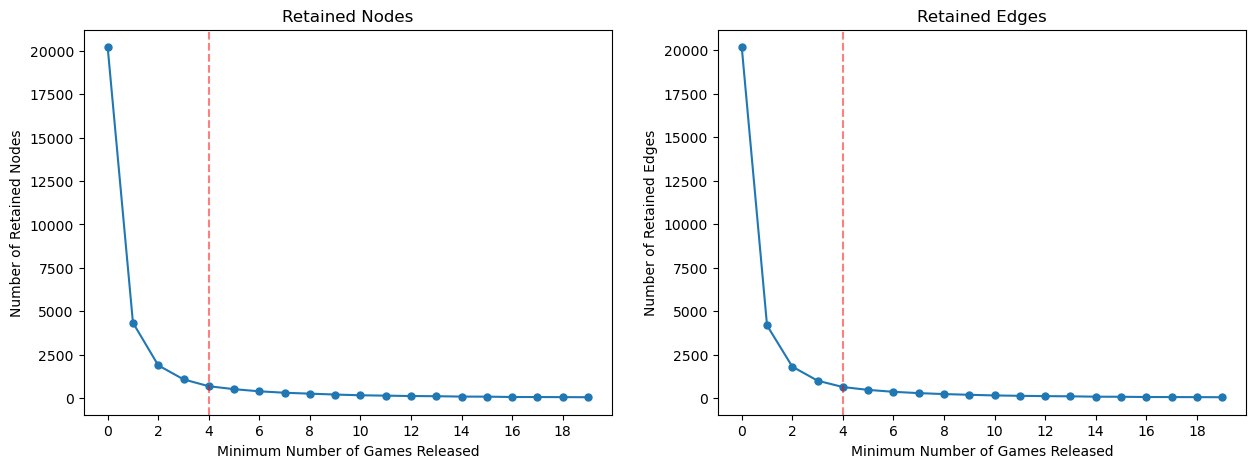

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for ax, retained, entity in zip(axes.flat,
                      [retained_nodes, retained_edges],
                      ['Nodes', 'Edges']):
    ax.plot(retained, marker='o', markersize=5)
    ax.set_title(f'Retained {entity}')
    ax.set_xlabel('Minimum Number of Games Released')
    ax.set_ylabel(f'Number of Retained {entity}')
    ax.set_xticks(range(0, 20, 2))
    ax.axvline(x=4, c='r', ls='--', alpha=0.5)
plt.show()

## $4$-core Steam network

In [23]:
num_games = 4
df_filtered = (
    df_weighted_edges[(df_weighted_edges.weight > num_games) &
                      (df_weighted_edges.node1 != df_weighted_edges.node2)]
)
df_filtered.loc[:, 'node1'] = df_filtered.node1.apply(unidecode)
df_filtered.loc[:, 'node2'] = df_filtered.node2.apply(unidecode)

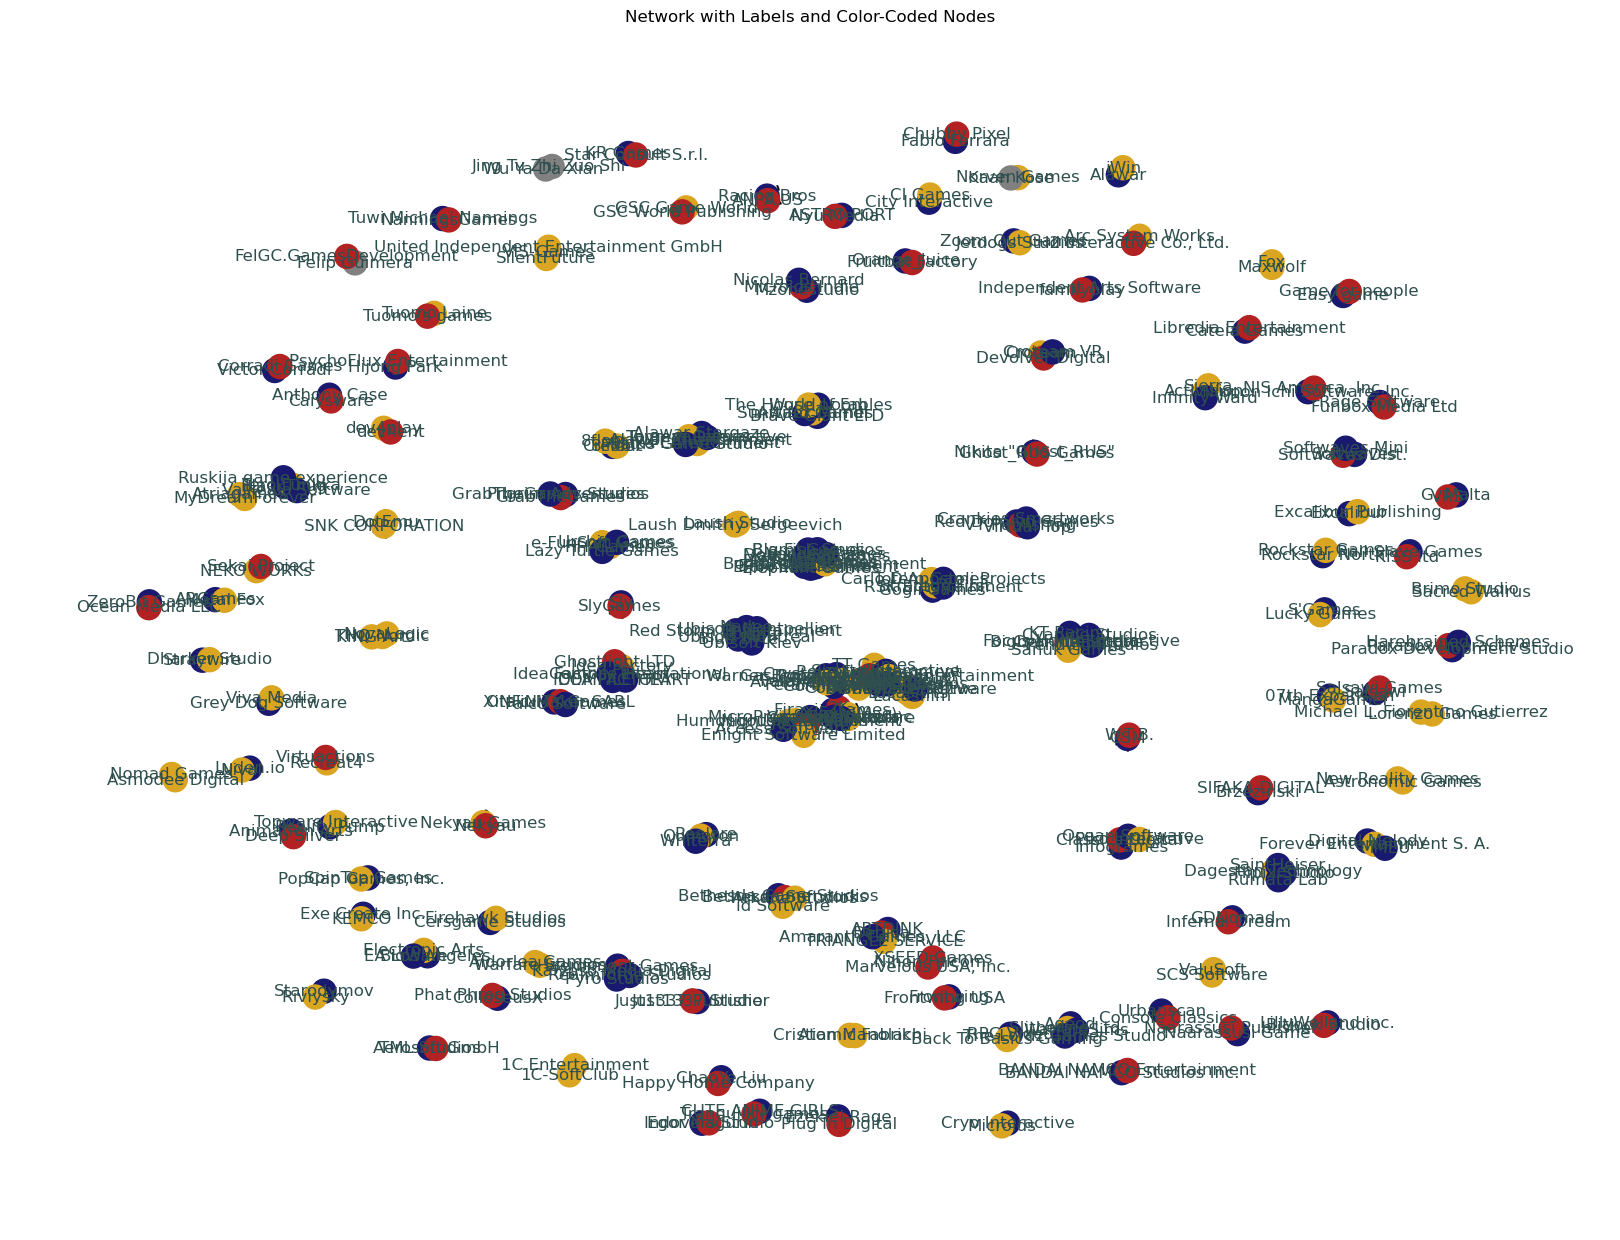

In [142]:
G = nx.from_pandas_edgelist(df_filtered, 'node1', 'node2', edge_attr='weight',
                            create_using=nx.Graph())

# Position nodes for visualization (you can use other layout algorithms as well)
pos = nx.spring_layout(G, seed=0)

# Draw nodes with different colors based on their roles
node_colors = []
for node in G.nodes():
    if node in dev_only:
        node_colors.append('midnightblue')
    elif node in pub_only:
        node_colors.append('firebrick')
    elif node in dev_pub:
        node_colors.append('goldenrod')
    else:
        node_colors.append('gray')  # For nodes not in any defined roles

# Draw the network with labels and colored nodes
plt.figure(figsize=(16, 12))
nx.draw(G, pos, with_labels=True, node_size=300, node_color=node_colors, font_size=12, font_color='darkslategray')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=15)
plt.title("Network with Labels and Color-Coded Nodes")
plt.show()

In [154]:
component_sizes.head(10)

2     33
3     12
33     7
7      7
28     6
6      6
21     5
17     5
35     4
77     4
dtype: int64

In [208]:
len(top_dev_pub)

45

In [207]:
components = np.array(list(nx.connected_components(G)))

# Count the number of nodes in each component
component_sizes = pd.Series(
    {i: len(component) for i, component in enumerate(components)}
).sort_values(ascending=False)

top_dev_pub = set.union(*components[component_sizes.index[:2]])

In [217]:
pd.Series(list(top_dev_pub)).rename('developer_publisher').to_csv('developer_publisher.csv', index=False)

In [123]:
df_game_dev_pub = (
    df_main[df_main.developer.isin(top_dev_pub) |
            df_main.publisher.isin(top_dev_pub)]
    .applymap(unidecode)
)

df_game_dev_pub_weights = (
    pd.concat(
        [df_game_dev_pub[['name', 'developer']]
         .rename(columns={'name': 'game', 'developer': 'dev_pub'}),
         df_game_dev_pub[['name', 'publisher']]
         .rename(columns={'name': 'game', 'publisher': 'dev_pub'})]
    )
    .groupby(['game', 'dev_pub'])
    .size()
    .sort_values(ascending=False)
    .rename('weights')
    .reset_index()
)

45


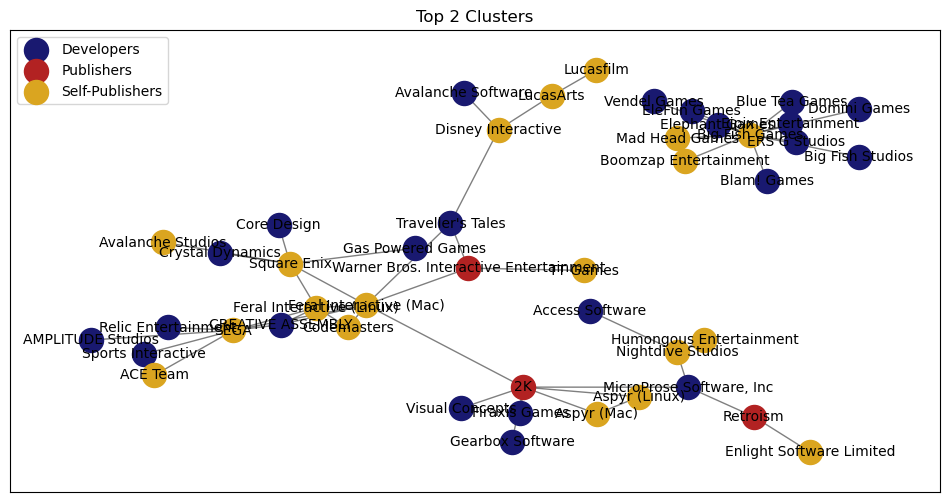

In [211]:
# Assuming you have already created your network and stored it in variable G
# And you have also computed the connected components and stored them in variable components

# Choose the index of the component you want to plot (e.g., 0 for the first component)

# Extract the subgraph corresponding to the chosen component
subgraph = G.subgraph(top_dev_pub)
print(len(subgraph.nodes))
node_colors = []
for node in subgraph.nodes():
    if node in dev_only:
        node_colors.append('midnightblue')
    elif node in pub_only:
        node_colors.append('firebrick')
    elif node in dev_pub:
        node_colors.append('goldenrod')
    else:
        node_colors.append('gray')

pos = nx.spring_layout(subgraph, k=0.5, seed=1)
        
# Plot the subgraph
plt.figure(figsize=(12, 6))
nx.draw_networkx_nodes(
    subgraph, pos,
    nodelist=np.array(subgraph.nodes)[np.argwhere(np.array(node_colors) == 'midnightblue').flatten()],
    node_color='midnightblue',
    label='Developers'
)
nx.draw_networkx_nodes(
    subgraph, pos,
    nodelist=np.array(subgraph.nodes)[np.argwhere(np.array(node_colors) == 'firebrick').flatten()],
    node_color='firebrick',
    label='Publishers'
)
nx.draw_networkx_nodes(
    subgraph, pos,
    nodelist=np.array(subgraph.nodes)[np.argwhere(np.array(node_colors) == 'goldenrod').flatten()],
    node_color='goldenrod',
    label='Self-Publishers'
)
nx.draw_networkx_edges(subgraph, pos, alpha=0.5)

# Draw node labels
nx.draw_networkx_labels(subgraph, pos, font_size=10, font_color='black')
# nx.draw(subgraph, with_labels=True, node_size=300, font_size=10)
plt.title(f"Top 2 Clusters")
plt.legend()
plt.show()

In [225]:
pd.Series(nx.degree_centrality(subgraph)).sort_values(ascending=False).head(10)

Big Fish Games                            0.250000
Feral Interactive (Mac)                   0.181818
SEGA                                      0.159091
2K                                        0.159091
Square Enix                               0.136364
Feral Interactive (Linux)                 0.113636
Disney Interactive                        0.068182
MicroProse Software, Inc                  0.068182
Warner Bros. Interactive Entertainment    0.068182
Traveller's Tales                         0.068182
dtype: float64

In [224]:
pd.Series(nx.betweenness_centrality(subgraph)).sort_values(ascending=False).head(10)

Feral Interactive (Mac)                   0.371564
2K                                        0.285412
MicroProse Software, Inc                  0.149049
Square Enix                               0.124736
SEGA                                      0.124736
Traveller's Tales                         0.118393
Disney Interactive                        0.094080
Nightdive Studios                         0.064482
Big Fish Games                            0.058140
Warner Bros. Interactive Entertainment    0.032770
dtype: float64

In [226]:
pd.Series(nx.closeness_centrality(subgraph)).sort_values(ascending=False).head(10)

Feral Interactive (Mac)                   0.342246
2K                                        0.302243
Feral Interactive (Linux)                 0.267503
Traveller's Tales                         0.261491
SEGA                                      0.261491
Square Enix                               0.258586
Warner Bros. Interactive Entertainment    0.252964
CREATIVE ASSEMBLY                         0.250244
Big Fish Games                            0.250000
MicroProse Software, Inc                  0.237477
dtype: float64

In [227]:
pd.Series(nx.eigenvector_centrality(subgraph)).sort_values(ascending=False).head(10)

Feral Interactive (Mac)                   0.520032
Feral Interactive (Linux)                 0.412935
SEGA                                      0.385385
CREATIVE ASSEMBLY                         0.314539
Square Enix                               0.288216
Codemasters                               0.222592
2K                                        0.201845
Traveller's Tales                         0.177637
Warner Bros. Interactive Entertainment    0.176500
ACE Team                                  0.091947
dtype: float64

In [124]:
# Create an empty bipartite graph
G = nx.Graph()

# Add nodes from 'node1' column as one set of nodes (e.g., developers)
G.add_nodes_from(df_game_dev_pub_weights['game'], bipartite=0)

# Add nodes from 'node2' column as the other set of nodes (e.g., publishers)
G.add_nodes_from(df_game_dev_pub_weights['dev_pub'], bipartite=1)

# Add edges with weights from the DataFrame
for row in df_game_dev_pub_weights.iterrows():
    node1 = row[1]['game']
    node2 = row[1]['dev_pub']
    weight = row[1]['weights']
    G.add_edge(node1, node2, weight=weight)

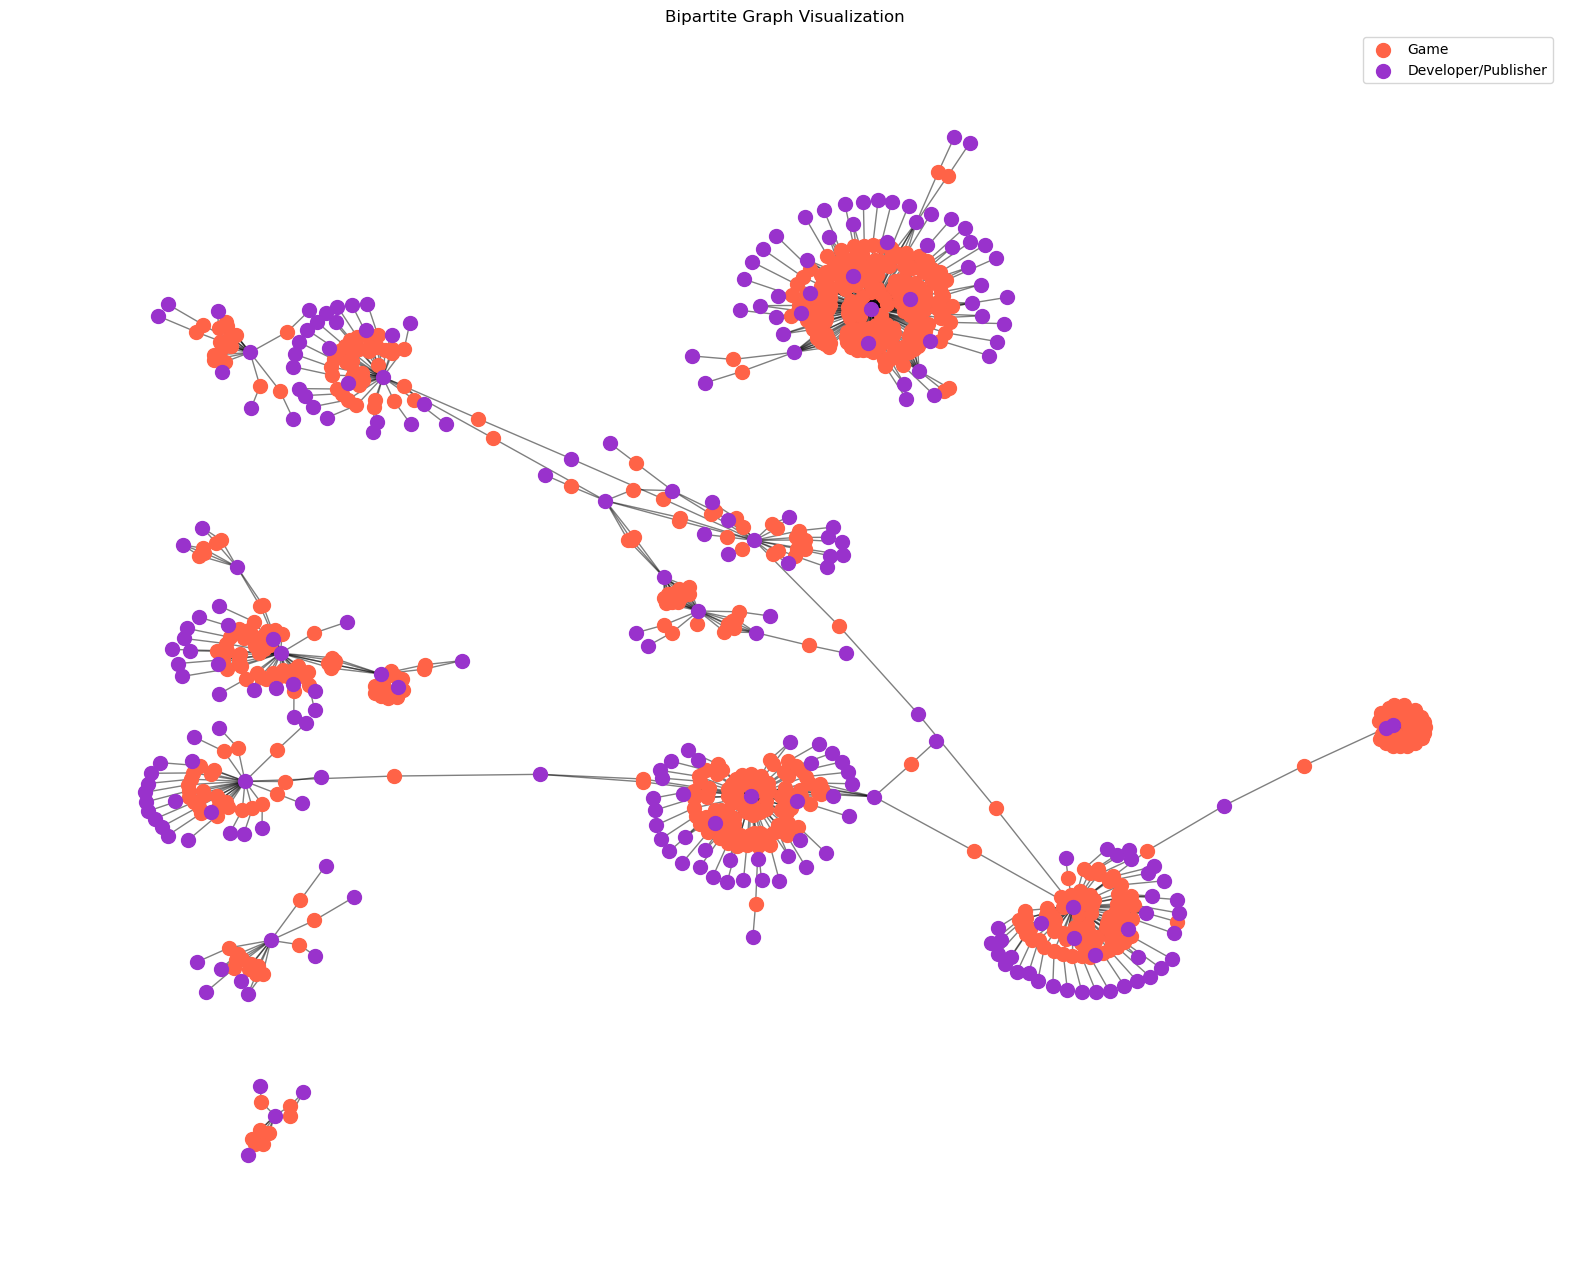

In [131]:
# Separate nodes into two lists based on their bipartite attribute
nodes1 = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]  # Nodes of set 1
nodes2 = [n for n, d in G.nodes(data=True) if d['bipartite'] == 1]  # Nodes of set 2

# Set node colors based on the bipartite attribute
node_colors = ['tomato' if d['bipartite'] == 0 else 'darkorchid' for _, d in G.nodes(data=True)]

# Draw the graph
plt.figure(figsize=(20, 16))
pos = nx.spring_layout(G, seed=0)  # Change layout if needed
nx.draw_networkx_nodes(G, pos, nodelist=nodes1, node_color='tomato',
                       node_size=100, label='Game')
nx.draw_networkx_nodes(G, pos, nodelist=nodes2, node_color='darkorchid',
                       node_size=100, label='Developer/Publisher')
nx.draw_networkx_edges(G, pos, alpha=0.5)
# nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Bipartite Graph Visualization")
plt.axis('off')
plt.legend()
plt.show()

In [137]:
df_games_bet = pd.Series(nx.betweenness_centrality(games_graph)).sort_values(ascending=False)

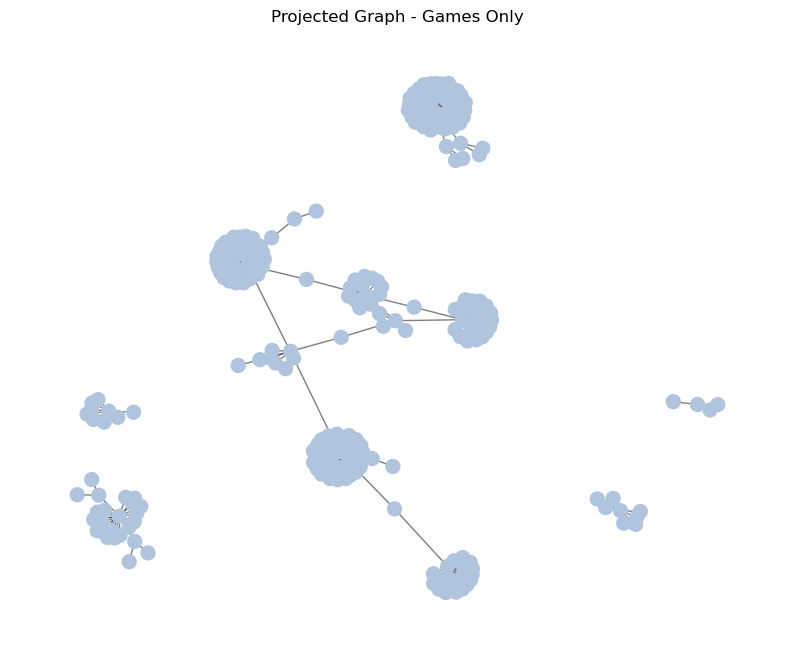

In [141]:
# Project the bipartite graph onto the games nodes
games_graph = nx.bipartite.projected_graph(G, nodes=nodes2)

node_colors = [
    'gold' if node in df_games_bet[df_games_bet > 0].index.tolist()
    else 'lightsteelblue'
    for node in games_graph.nodes
]

# Plot the projected graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(games_graph)  # Change layout if needed
nx.draw_networkx_nodes(games_graph, pos, node_color=node_colors, node_size=100)
nx.draw_networkx_edges(games_graph, pos, alpha=0.5)
# nx.draw_networkx_labels(games_graph, pos, font_size=8)

plt.title("Projected Graph - Games Only")
plt.axis('off')
plt.show()


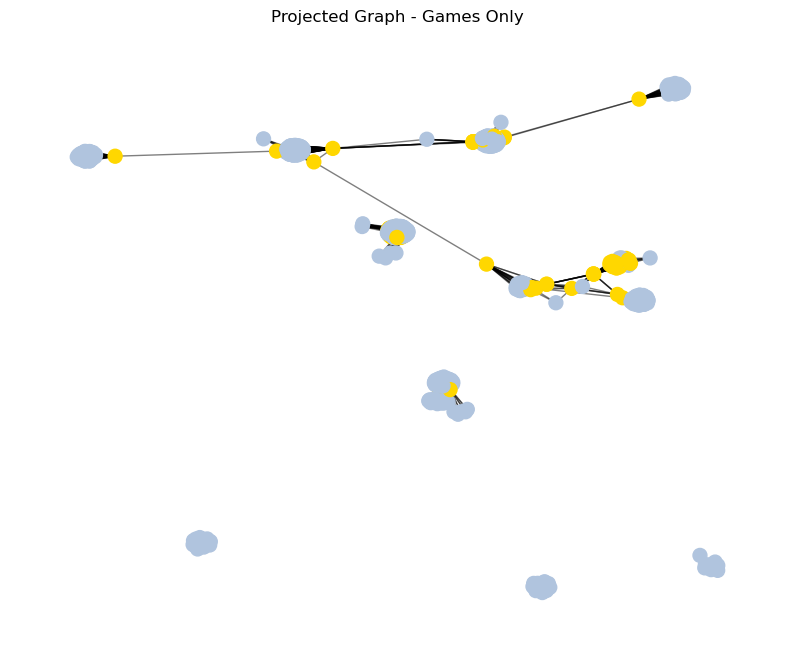

In [140]:
# Project the bipartite graph onto the games nodes
games_graph = nx.bipartite.projected_graph(G, nodes=nodes1)

node_colors = [
    'gold' if node in df_games_bet[df_games_bet > 0].index.tolist()
    else 'lightsteelblue'
    for node in games_graph.nodes
]

# Plot the projected graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(games_graph)  # Change layout if needed
nx.draw_networkx_nodes(games_graph, pos, node_color=node_colors, node_size=100)
nx.draw_networkx_edges(games_graph, pos, alpha=0.5)
# nx.draw_networkx_labels(games_graph, pos, font_size=8)

plt.title("Projected Graph - Games Only")
plt.axis('off')
plt.show()
